In [16]:
# !pip3 install xmltodict
# !pip3 install untangle
# !pip3 install nameparser
# !pip3 install pandas
# !pip3 install uszipcode
# !pip3 install pygraphviz

import turicreate as gl
from turicreate import SFrame, SArray, SGraph
import xmltodict, untangle
from nameparser import HumanName
import pandas as pd
import itertools
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz
import matplotlib.pyplot as plt
from uszipcode import ZipcodeSearchEngine
import math

def get_forms(x):
    utp = untangle.parse(x)
    rdlist = dir(utp.Return.ReturnData)
    return [str(item) for item in rdlist]

def get_header_type(x):
    utp = untangle.parse(x)
    return utp.Return.ReturnHeader.ReturnType.cdata.encode('ascii')

def load_value(x,field):
    try:
        utp = untangle.parse(x)
        utp_data = utp.Return.ReturnData
        return get_value(utp_data.IRS990,field)
    except:
        return None
def get_value(source,field):
    try:
        return getattr(source,field).cdata
    except:
        return None
    
    
def get_peoplenames(x):
    try:
        utp = untangle.parse(x)
        utp_data = utp.Return.ReturnData.IRS990.Form990PartVIISectionA
        namelist = []
        for i in utp_data:
            raw_name = i.NamePerson.cdata
            name = HumanName(raw_name)
            namelist.append(str(name))
        return namelist
    except:
        print('nothin')
        return None
    
def get_officer_names(officers):
    officer_names = []
    count = 0
    for off in officers:
        # avoid formatting errors
        try:
            if 'NamePerson' in list(off.keys()):
                officer_names.append(off['NamePerson'])
            elif 'PersonNm' in list(off.keys()):
                officer_names.append(off['PersonNm'])
            else:
                print('woah')
        except: 
            continue
    return officer_names


 
'''
('NamePerson', 'STEVE BEDITZ'),
('Title', 'DIRECTOR'),
('AverageHoursPerWeek', '1.00'),
('IndividualTrusteeOrDirector', 'X'),
('ReportableCompFromOrganization', '0'),
('ReportableCompFromRelatedOrgs', '0'),
('OtherCompensation', '0')]),
'''
class Officer:
    def __init__(self, name, title, hours, salary):
        self.name = name
        self.salary = int(salary)
        self.hours = float(hours)
        self.title = title
        
    def set_org_name(self, org_name):
        self.org_name = org_name
        
    def get_org_name(self):
        return self.org_name
        
    def get_name(self):
        return self.name
    
    def get_salary(self):
        return self.salary
    
    def get_hours(self):
        return self.hours
    
    def get_title(self):
        return self.title
    
    def print_self(self):
        print(self.name, self.title, self.hours, self.salary)

class Charity:
    def __init__(self, xml):
        dic = xmltodict.parse(xml)
        
        # ADDING CHARITY NAME
        charity_name_root = dic['Return']['ReturnHeader']['Filer']
        if 'Name' in charity_name_root.keys():
            self.org_name = charity_name_root['Name']['BusinessNameLine1']
        elif 'BusinessName' in charity_name_root.keys():
            try:
                self.org_name = charity_name_root['BusinessName']['BusinessNameLine1']
            except:
                print(charity_name_root['BusinessName'].keys())
                self.org_name = 'Not Parseable'

        # GENERAL INFORMATION
        try:
            self.relevant_data = dic['Return']['ReturnData']['IRS990']
        except:
            print(dic['Return']['ReturnData'].keys())
            
           
            
            
            
        # ADDING CHARITY OFFICERS
        # non-2015 filing format
        self.officers = []
        if 'Form990PartVIISectionA' in self.relevant_data.keys():
            officers_dict = self.relevant_data['Form990PartVIISectionA']
            for off in officers_dict:
                try: # formatting errors
                    name = ''
                    if 'NamePerson' in list(off.keys()):
                        name = off['NamePerson']
                        #officer_names.append(off['NamePerson'])
                    elif 'PersonNm' in list(off.keys()):
                        name = off['NamePerson']
                    salary = off['ReportableCompFromOrganization']
                    hours = off['AverageHoursPerWeek']
                    title = off['Title']
                    o = Officer(name, title, hours, salary)
                    o.set_org_name(self.org_name)
                    self.officers.append(o)
                except:
                    continue
        # 2015 filing format
#         elif 'Form990PartVIISectionAGrp'in self.relevant_data.keys():
#             self.officers = self.relevant_data['Form990PartVIISectionAGrp']
            
    def has_officer(name):
        for o in self.officers:
            if o.get_name() == name:
                return True
        return False
            
    def return_org_name(self):
        return self.org_name
    def return_info(self):
        return self.relevant_data
    def return_officers(self):
        return self.officers
    def print_officers(self):
        for o in self.officers:
            o.print_self()
    
    # just a plain list of names
    def return_officers_bare(self):
        officer_names = []
        for off in self.officers:
            # avoid formatting errors
            try:
                if 'NamePerson' in list(off.keys()):
                    officer_names.append(off['NamePerson'])
                elif 'PersonNm' in list(off.keys()):
                    officer_names.append(off['PersonNm'])
                else:
                    print('woah')
            except: 
                continue
        return officer_names
    

def graph_component(Gc):
    # Color charities blue and larger with yellow labels
    color_map = []
    charity_names = [c.return_org_name() for c in charities]
    node_sizes = []
    char_labels = {}
    off_labels = {}
    for node in Gc:
        if node in charity_names:
            color_map.append('blue')
#             node_sizes.append(1000)
            node_sizes.append(Gc.degree()[node] * 400)
            char_labels[node] = node
        else:
            color_map.append('red')
#             node_sizes.append(200)
            node_sizes.append(Gc.degree()[node] * 60)
            off_labels[node] = node

    # # Separate by group
    l, r = nx.bipartite.sets(Gc)
    pos = {}

    # # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, (len(l) / ((len(r) + 1)) * index))) for index, node in enumerate(r))

    # pos = graphviz_layout(Gc)
    nx.draw(Gc, pos, node_color=color_map, node_size=node_sizes, with_labels=False)
    nx.draw_networkx_labels(Gc, pos, char_labels, font_weight='bold', font_color='r')
    nx.draw_networkx_labels(Gc, pos, off_labels, font_weight='normal', font_color='k')

plt.rcParams['figure.figsize'] = [30, 30]

In [2]:

# sfm = SFrame('sfmain_saved/')
# troy = sfm.filter_by('990', 'RETURN_TYPE') # filter by only 990 forms
# troy = troy.filter_by(201212, 'TAX_PERIOD') # filter by 2012 tax period
# troy.save('sframe-990-period-201212')
troy = SFrame('sframe-990-period-201212')

In [ ]:
# FILTERING BY LOCATION
search = ZipcodeSearchEngine()
zipcodes = [z['Zipcode'] for z in search.by_city("Los Angeles", returns=0)]
print('Filtering by State...')
print(zipcodes)
troy = troy.filter_by(zipcodes,'zip_code')    # filter by Troy, TAKES ~2 MINUTES TO RUN=
troy.show()

In [ ]:
# LOAD CHARITY OBJECTS FROM XMLs
troy = troy.filter_by('990', 'RETURN_TYPE')
charities = []
for filing in troy:
    charities.append(Charity(filing['return_info']))   
charities[0].return_officers()

In [ ]:
# Get a list of officers
'''
|Name            | Title    | Hours | Salary|
|----------------|----------|-------|-------|
|STEVE BEDITZ    | DIRECTOR | 1.0   | 0     |
|----------------|----------|-------|-------|
|ANGELA MCNERNEY | DIRECTOR | 40.0  | 80000 |
|----------------|----------|-------|-------|
| .....          |.....     |....   |....
|----------------|----------|-------|-------|
'''

# officer dataframe
odf = pd.DataFrame(columns=['Name', 'TotalHours', 'TotalSalary', 'Organization'])
# odf.loc[len(odf)] = ['Bob', 13, 31351]
for charity in charities:
    officer_objects = charity.return_officers()
    for officer in officer_objects:
        odf.loc[len(odf)] = [officer.get_name(), officer.get_hours(), officer.get_salary(), officer.get_org_name()] 

officer_sframe = SFrame(data=odf)
# officer_sframe.show()

In [ ]:
odf = odf.sort_values('Organization', ascending=False)
# odf

In [ ]:
## CREATE BI-PARTITE GRAPH ## 

B = nx.Graph()

# Get list of officers and add to graph
list_of_officers = []
for charity in charities:
    for officer in charity.return_officers():
        list_of_officers.append(officer.get_name())
B.add_nodes_from(list_of_officers, bipartite=0)


# Get list of charities and add to graph
list_of_charities = [c.return_org_name() for c in charities]
B.add_nodes_from(list_of_charities, bipartite=1)

# Bipartite edges
edges = []
for charity in charities:
    for officer in charity.return_officers():
        edges.append((officer.get_name(), officer.get_org_name()))
B.add_edges_from(edges)

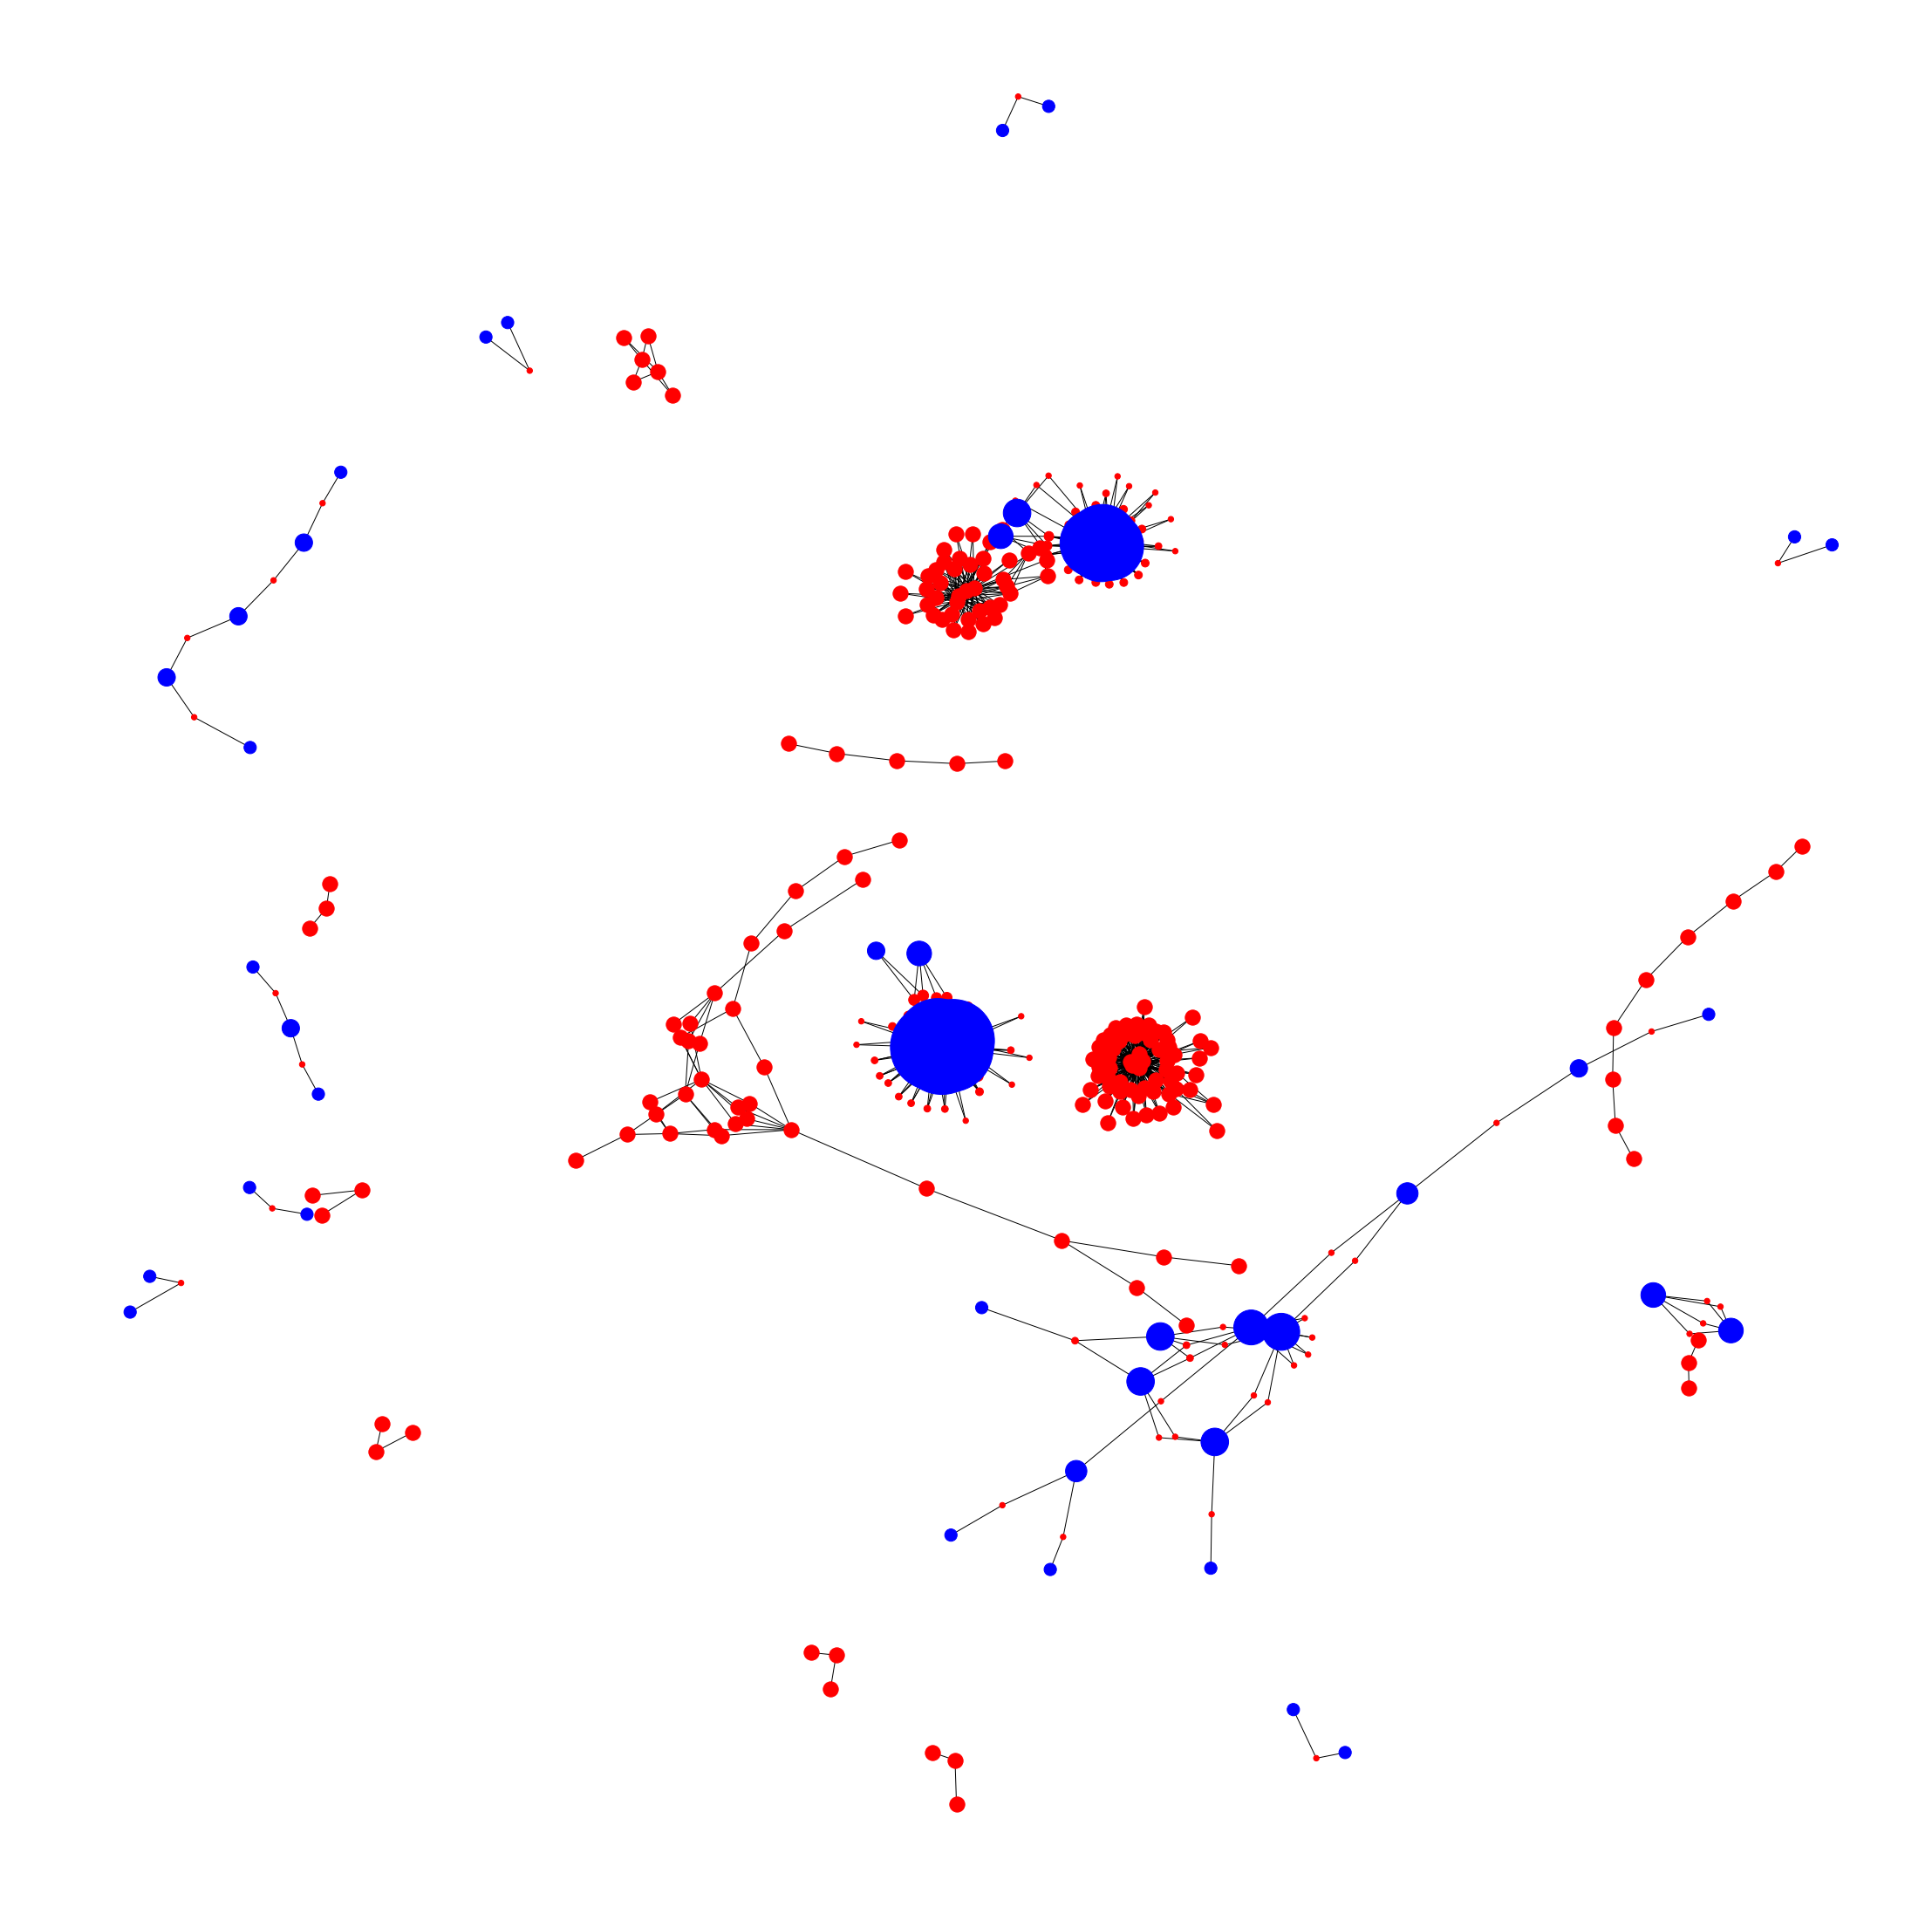

In [20]:
nx.draw(B)
Gc = B
# Color charities blue and larger with yellow labels
color_map = []
charity_names = [c.return_org_name() for c in charities]
node_sizes = []
char_labels = {}
off_labels = {}
for node in Gc:
    if node in charity_names:
        color_map.append('blue')
#             node_sizes.append(1000)
        node_sizes.append((Gc.degree()[node]) * 200)
        char_labels[node] = node
    else:
        color_map.append('red')
#             node_sizes.append(200)
        node_sizes.append((Gc.degree()[node]) * 20)
        off_labels[node] = node

pos = nx.spring_layout(Gc)
nx.draw(Gc, pos, node_color=color_map, node_size=node_sizes, with_labels=False)
# nx.draw_networkx_labels(Gc, pos, char_labels, font_weight='bold', font_color='r')
# nx.draw_networkx_labels(Gc, pos, off_labels, font_weight='normal', font_color='k')

In [9]:
# Find most connected individuals
B.remove_nodes_from([node for node in B if B.degree(node) < 2]) # Remove nodes with less than 2 edges (officers who only work at one charity)
B.remove_nodes_from([node for node in B if B.degree(node) == 0]) # Now remove charities with no officers who have less than two edges
# We're left with no 'Stars' / charities with no connected officers
# nx.draw(B)

In [10]:
plt.rcParams['figure.figsize'] = [30, 30]

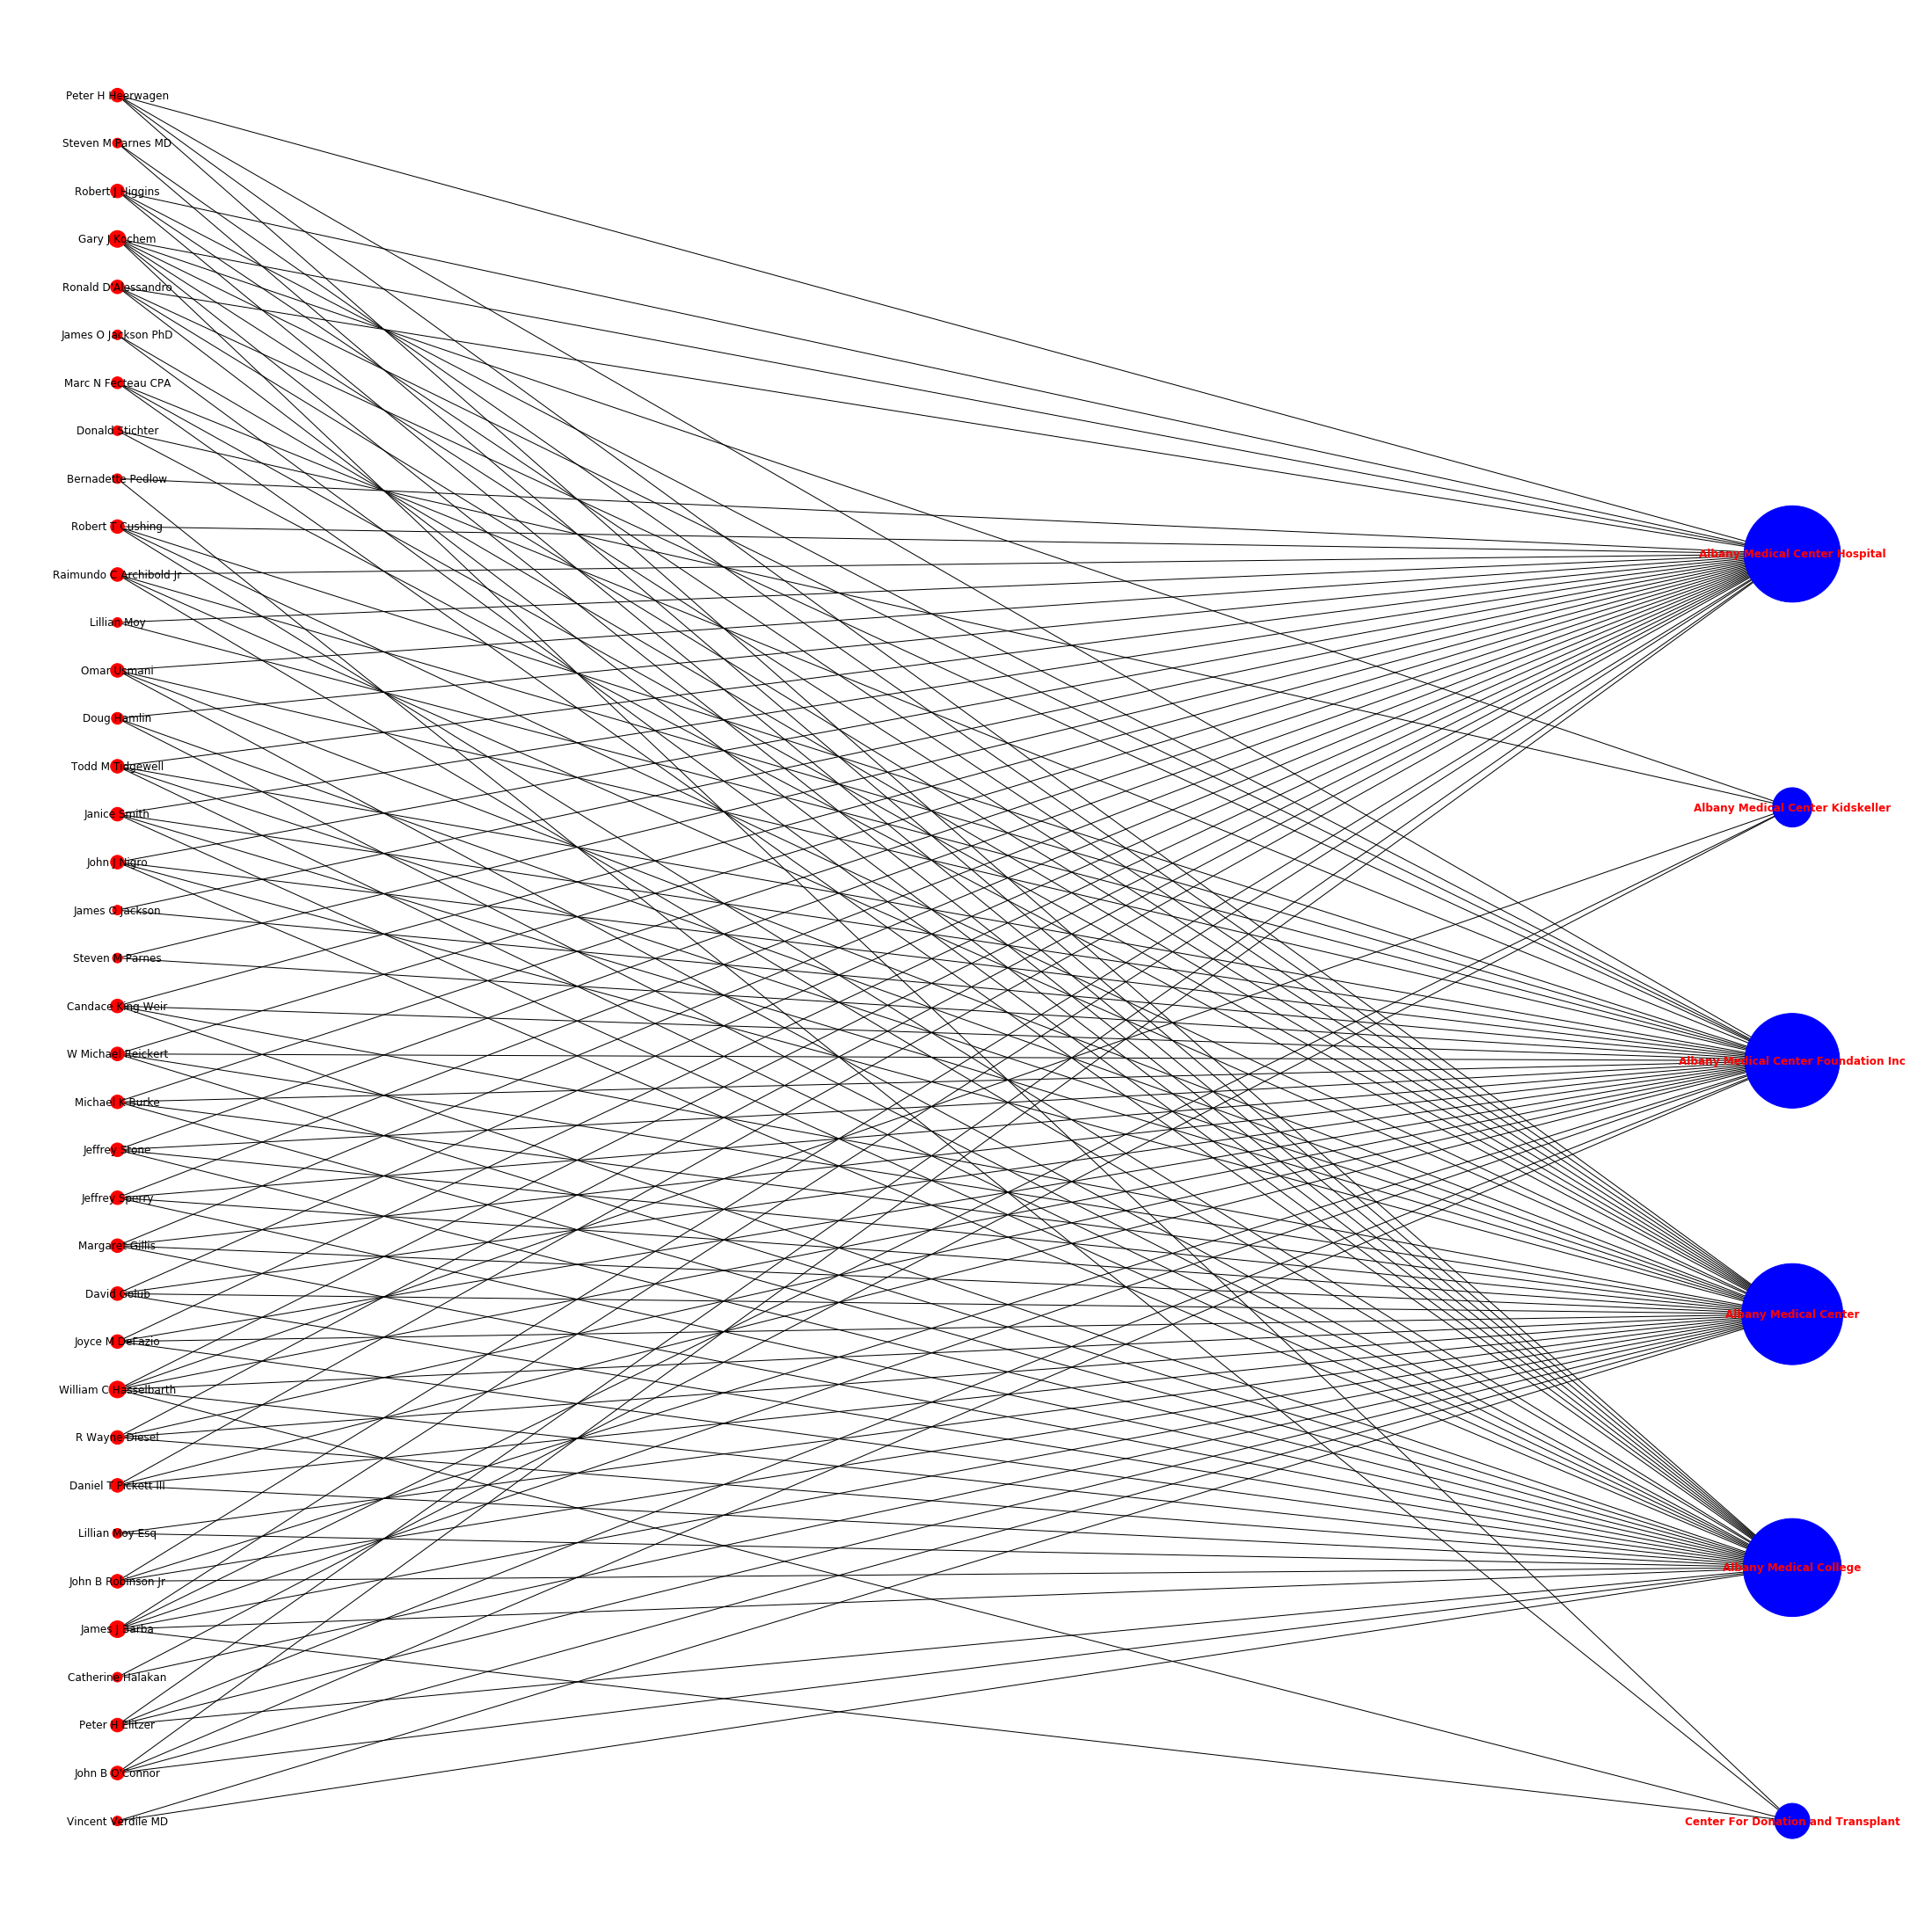

In [11]:
# Find largest connected component and only vizualize that
Gc = sorted((B.subgraph(c).copy() for c in nx.connected_components(B)), key=len)[-2]   
graph_component(Gc)

In [12]:
l, r = nx.bipartite.sets(Gc)

# Officer degree distribution
officer_degrees = SFrame([x[1] for x in list(Gc.degree(l))])
officer_degrees.show()

Materializing SFrame...

Done.

In [13]:
# Charity degree distribution
charity_degrees = SFrame([x[1] for x in list(Gc.degree(r))])
charity_degrees.show()

Materializing SFrame...

Done.

In [14]:
# Now we work with the salaries
# chars, offs = nx.bipartite.sets(Gc)
# salaries = {}
# for off in offs:   # find officers and their summative salaries
#     for charity in charities:
#         for officer in charity.return_officers():
#             if off == officer.get_name():
# #                 if officer.get_name() in salaries.keys():
#                 updated_salary = 
#                 salaries.update({officer.get_name(): salaries[officer.get_salary()] += officer.get_salary()})
# #                 salaries[officer.get_name()] += officer.get_salary()
# print(salaries)


In [15]:
# officer dataframe
odf = pd.DataFrame(columns=['Name', 'TotalHours', 'TotalSalary', 'Organization'])
for off in offs:   # find officers and their summative salaries
    for charity in charities:
        for officer in charity.return_officers():
            if off == officer.get_name():
                odf.loc[len(odf)] = [officer.get_name(), officer.get_hours(), officer.get_salary(), officer.get_org_name()] 

officer_sframe = SFrame(data=odf)
# officer_sframe.show()
odf

NameError: name 'offs' is not defined

In [ ]:

math.log(5)